# Atlas-level integration of lung data

In [4]:
!pip install --quiet scvi-colab
!pip install --quiet scib-metrics
from scvi_colab import install

install(run_outside_colab=True)

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
import scanpy as sc
import scvi
from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde
from scvi_colab import install
import tqdm as notebook_tqdm
import pandas as pd

In [8]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [42]:
adata = sc.read("/home/h/hollenberg/MaPra/Peyser_Merging.h5ad")

In [43]:
adata

AnnData object with n_obs × n_vars = 18686 × 19472
    obs: 'batch', 'condition', 'manual_celltype_annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'

In [46]:
adata.obs[['GSM']] = adata.obs['condition'].str.split("_", expand = True)
adata.obs

,batch,condition,manual_celltype_annotation,GSM
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,saline,Interstitial Macrophage,saline
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,saline,B-cells,saline
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,saline,Lymphatic endothelial,saline
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,saline,Alveolar macrophages,saline
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,saline,Endothelial,saline
...,...,...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage,nintedanib
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage,nintedanib
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,nintedanib,Classical monocytes,nintedanib
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,nintedanib,B-cells,nintedanib


In [47]:
# TODO raw counts
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    batch_key="GSM",
    subset=True,
)

## Integration with scVI

In [48]:
scvi.model.SCVI.setup_anndata(adata, batch_key="GSM")

In [49]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [50]:
vae.train()

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/h/hollenberg/miniconda3/envs/scanpy/lib/python ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/h/hollenberg/miniconda3/envs/scanpy/lib/python ...
  rank_zero_warn(


Epoch 400/400: 100%|███████████████████████████████████| 400/400 [19:51<00:00,  2.91s/it, v_num=1, train_loss_step=675, train_loss_epoch=588]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████| 400/400 [19:51<00:00,  2.98s/it, v_num=1, train_loss_step=675, train_loss_epoch=588]


In [51]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [52]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)

In [53]:
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


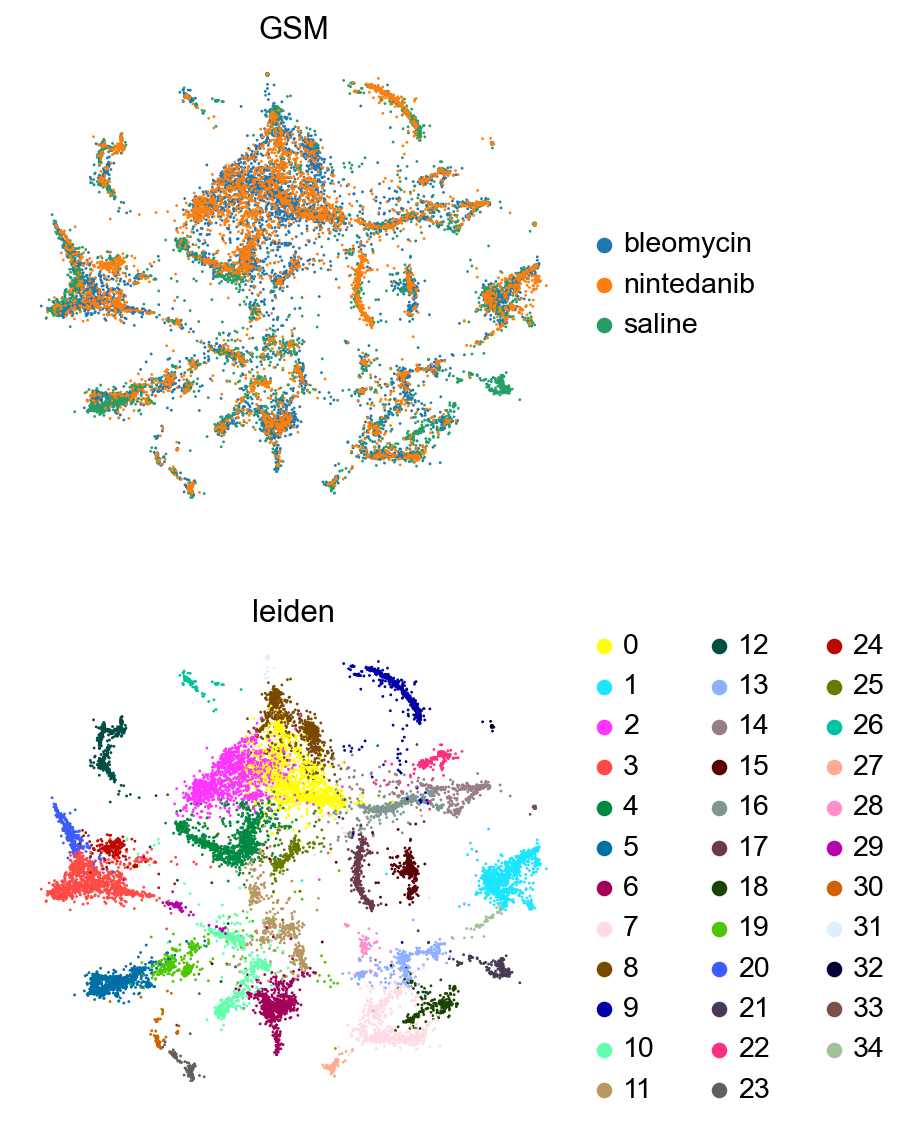

In [56]:
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["GSM", "leiden"],
    frameon=False,
    ncols=1,
)

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


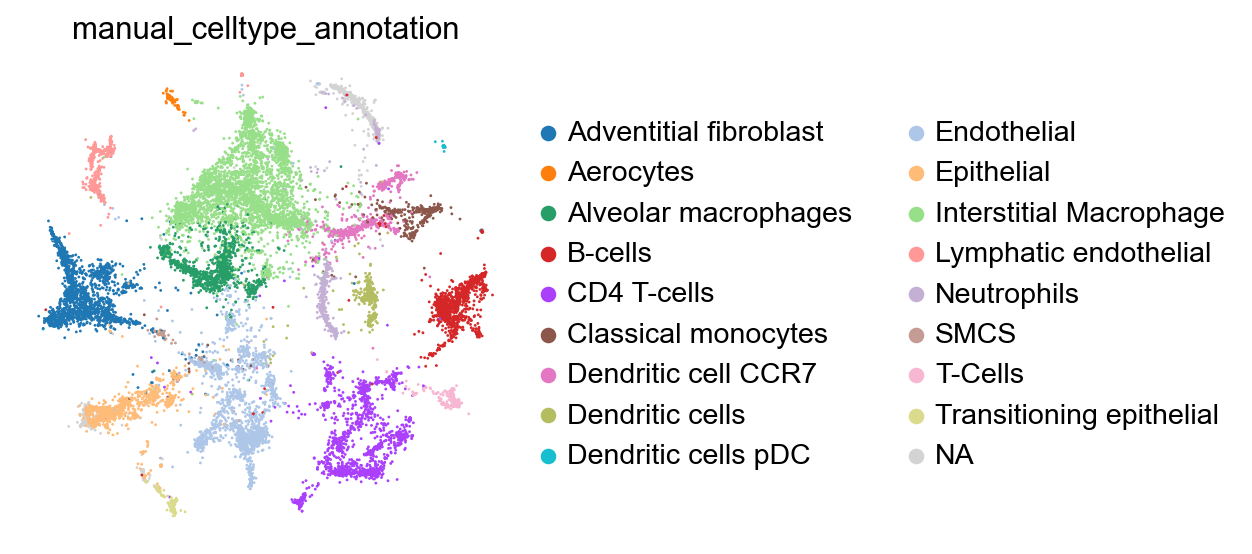

In [57]:
sc.pl.embedding(adata, basis="X_mde", color=["manual_celltype_annotation"], frameon=False, ncols=1)

## Integration with scANVI

In [ ]:
# Add the category 'unknown' to the existing categories
adata.obs['manual_celltype_annotation'] = adata.obs['manual_celltype_annotation'].cat.add_categories('unknown')

# Replace NaN values with 'unknown'
adata.obs['manual_celltype_annotation'].fillna('unknown', inplace=True)

In [100]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="manual_celltype_annotation",
    unlabeled_category="unknown",
)

In [101]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/h/hollenberg/miniconda3/envs/scanpy/lib/python ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/h/hollenberg/miniconda3/envs/scanpy/lib/python ...
  rank_zero_warn(


Epoch 20/20: 100%|███████████████████████████████████████| 20/20 [02:00<00:00,  6.00s/it, v_num=1, train_loss_step=661, train_loss_epoch=659]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████████████████████████████████| 20/20 [02:00<00:00,  6.02s/it, v_num=1, train_loss_step=661, train_loss_epoch=659]


In [102]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [103]:
adata.obsm["X_mde_scanvi"] = mde(adata.obsm["X_scANVI"])

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


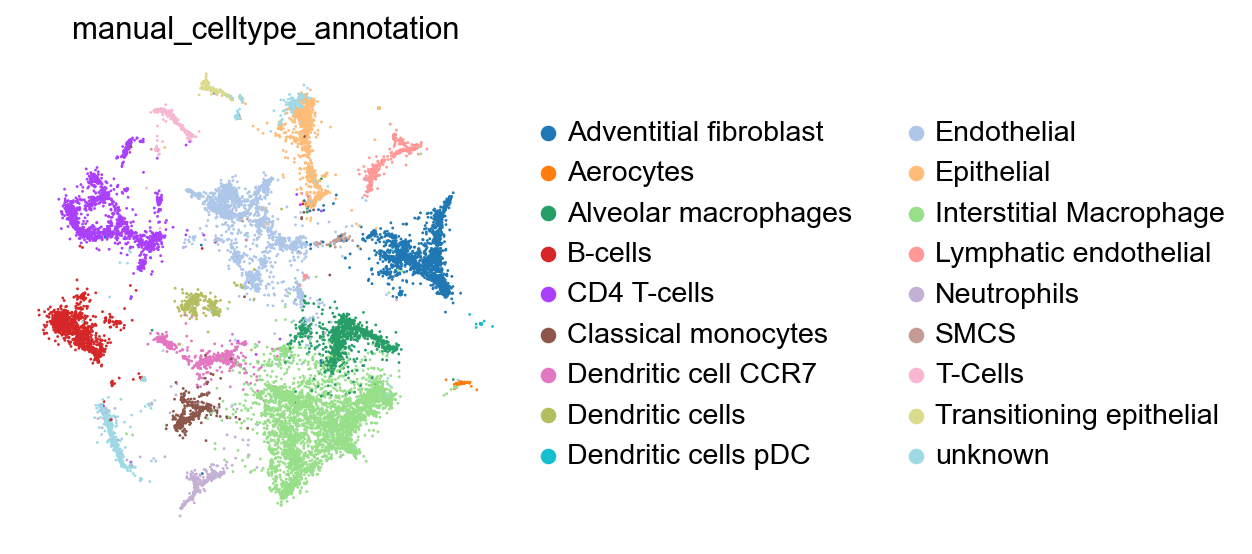

In [105]:
sc.pl.embedding(
    adata, basis="X_mde_scanvi", color=["manual_celltype_annotation"], ncols=1, frameon=False
)

## Compute integration metrics

In [106]:
bm = Benchmarker(
    adata,
    batch_key="GSM",
    label_key="manual_celltype_annotation",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI"],
    n_jobs=-1,
)
bm.benchmark()

Metrics:   0%|                                                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                                                             
Metrics:  80%|█████████████████████████████████████████████████▌            | 8/10 [00:42<00:11,  5.84s/it, Batch correction: pcr_comparison]/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|                                                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                                                             
Metrics:  80%|█████████████████████████████████

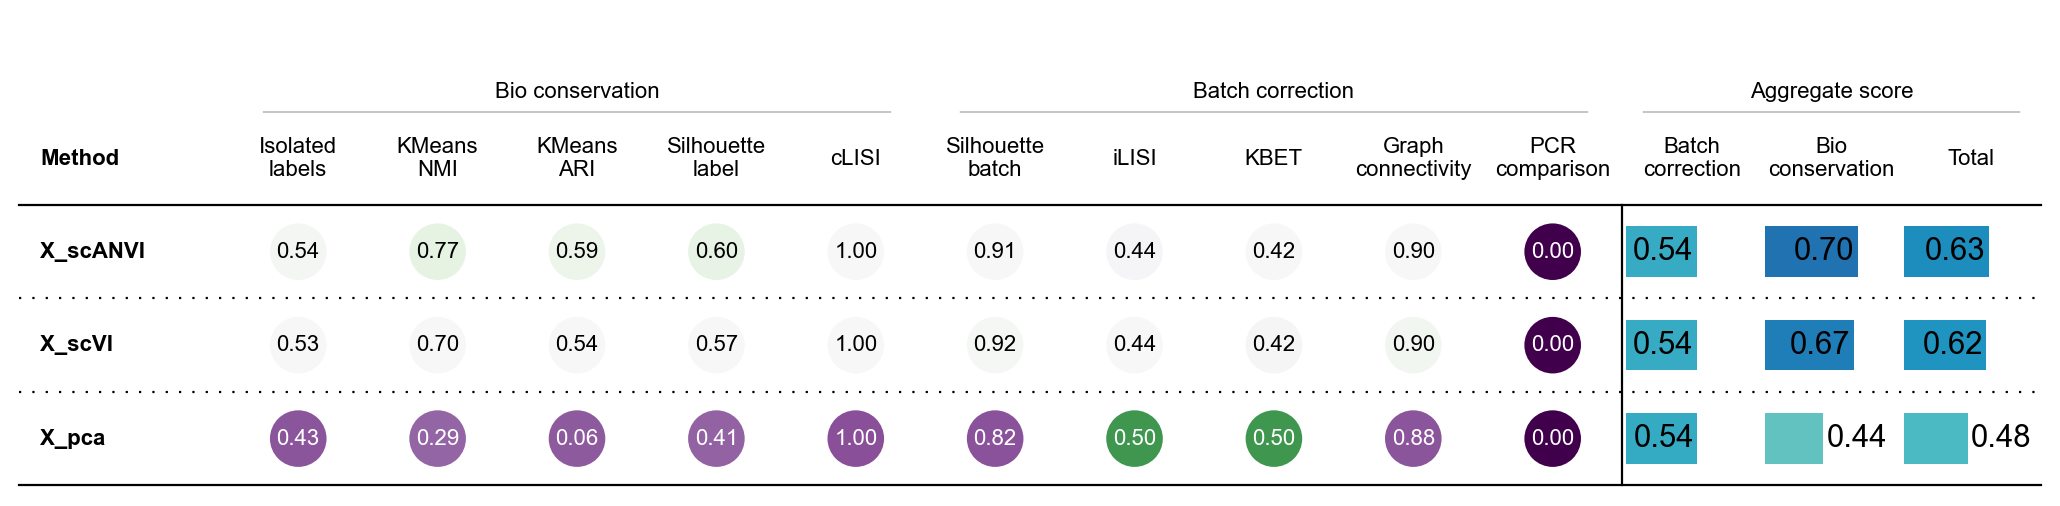

In [107]:
bm.plot_results_table(min_max_scale=False)

In [108]:
df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
X_pca                0.431105           0.28739          0.055898   
X_scVI               0.532314          0.698869          0.541477   
X_scANVI             0.536851          0.770677          0.590658   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
X_pca                0.411363          0.997913          0.818163   
X_scVI               0.572465               1.0          0.916085   
X_scANVI             0.598886               1.0          0.914045   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
X_pca                0.497085          0.503634           0.880887   
X_scVI               0.443757          0.422499           0.904095   
X_scANVI             0.442538          0.423801           0.903051   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
X_pca                     0.0         0.539954         0.436734   
X_scVI                      0         0.537287         0.669025   
X_scANVI                    0         0.536687         0.699414   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
X_pca               0.478022  
X_scVI               0.61633  
X_scANVI            0.634323  
Metric Type  Aggregate score

In [117]:
list(adata.obsm)

['X_scVI', 'X_mde', 'X_scANVI', 'X_mde_scanvi', 'X_pca']

Umap with basis X_scVI

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


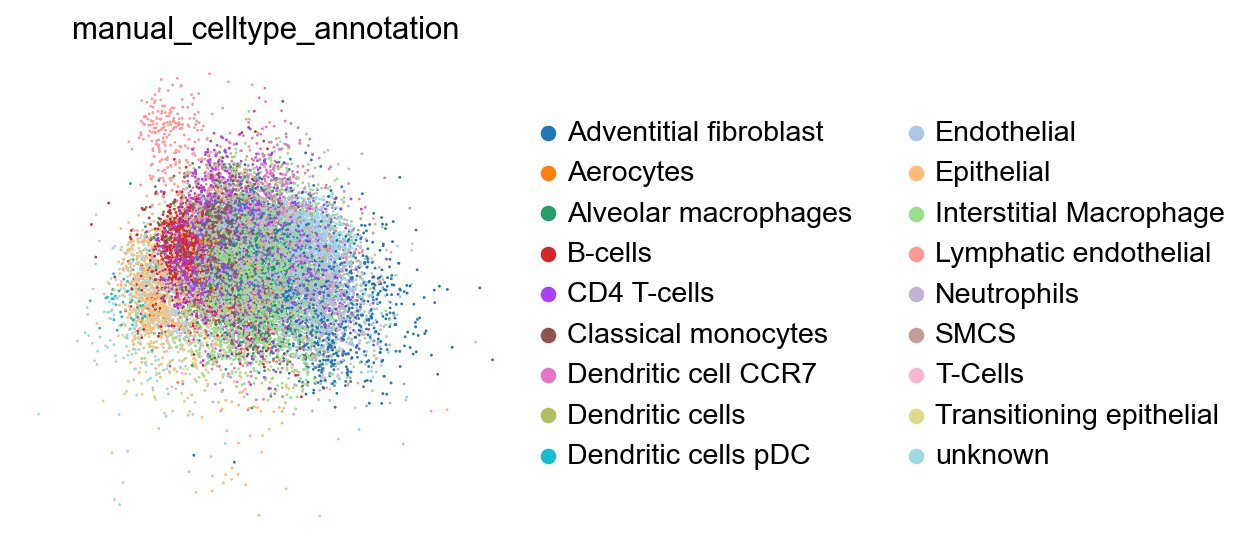

Umap with basis X_mde

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


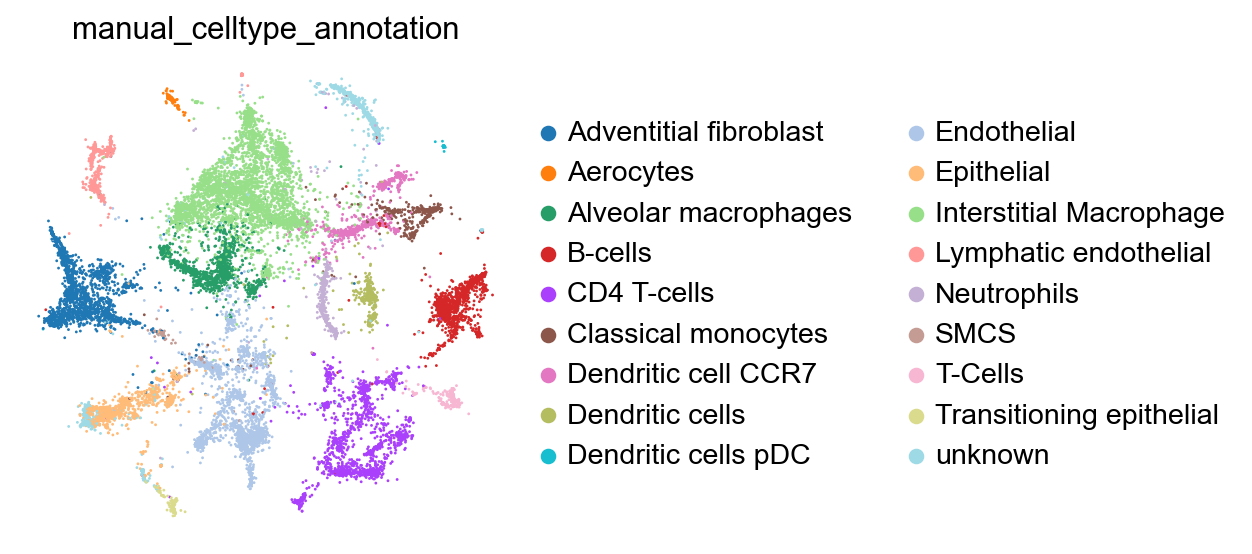

Umap with basis X_scANVI

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


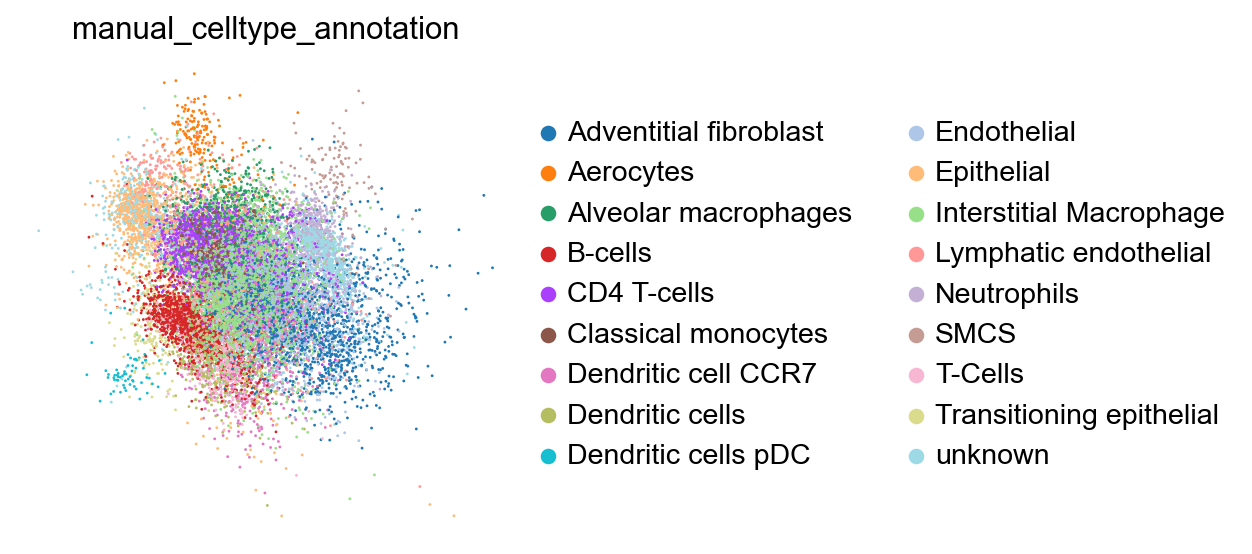

Umap with basis X_mde_scanvi

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


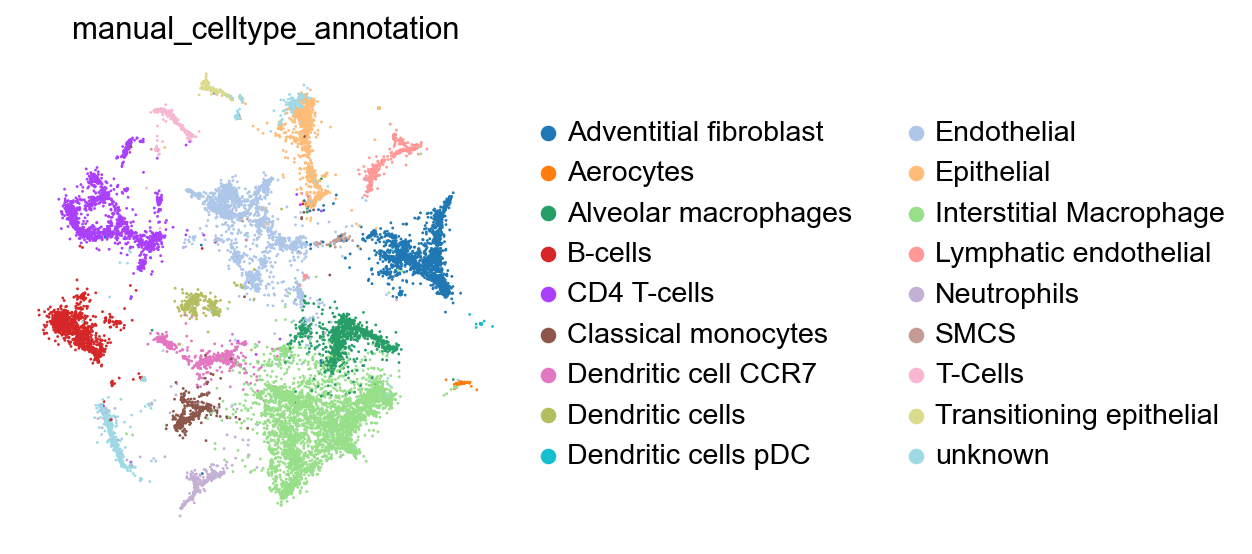

Umap with basis X_pca

/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


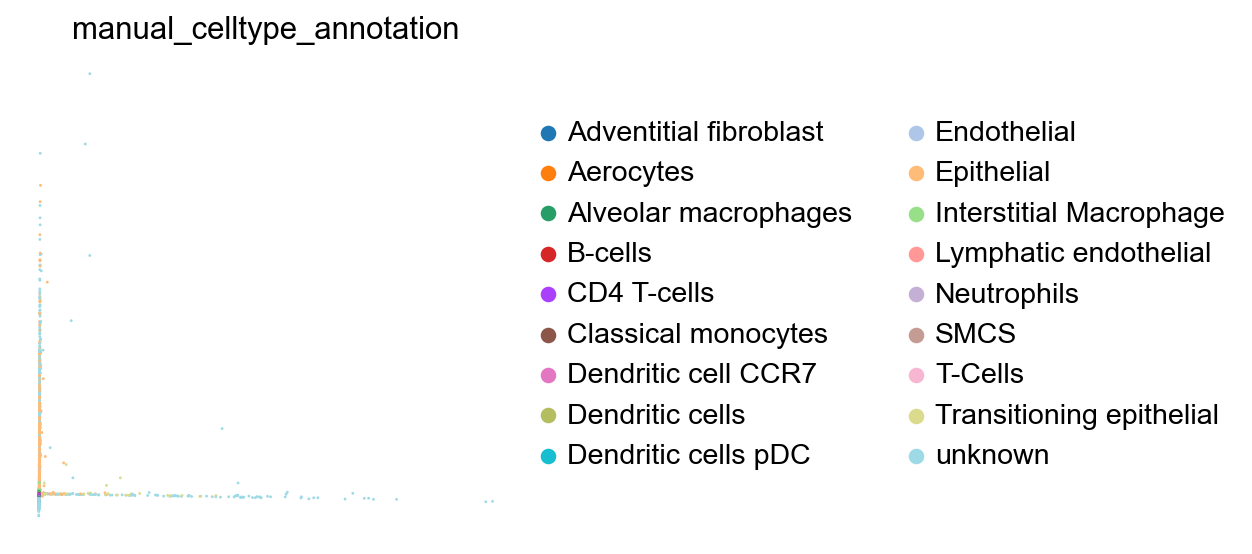

In [119]:
for emb in list(adata.obsm):
    print(f"Umap with basis {emb}")
    sc.pl.embedding(
        adata, basis=emb, color=["manual_celltype_annotation"], ncols=1, frameon=False
    )
